In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,recall_score, classification_report, precision_recall_curve, f1_score, accuracy_score, roc_curve, roc_auc_score, auc

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import dropout
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC

In [3]:
df = pd.read_csv("brain_stroke.csv")
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [5]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [6]:
cat_variables = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [7]:
for category in cat_variables:
    print(f"{category}: {df[category].unique()}")

gender: ['Male' 'Female']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [8]:
df['gender'] = [1 if i == 'Male' else 0 for i in df['gender']]
df['ever_married'] = [1 if i =='Yes' else 0 for i in df['ever_married']]
df['Residence_type'] = [1 if i =='Urban' else 0 for i in df['Residence_type']]
df = pd.get_dummies(df, columns = ['work_type', 'smoking_status'])

In [9]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,False,True,False,False,False,True,False,False
1,1,80.0,0,1,1,0,105.92,32.5,1,False,True,False,False,False,False,True,False
2,0,49.0,0,0,1,1,171.23,34.4,1,False,True,False,False,False,False,False,True
3,0,79.0,1,0,1,0,174.12,24.0,1,False,False,True,False,False,False,True,False
4,1,81.0,0,0,1,1,186.21,29.0,1,False,True,False,False,False,True,False,False


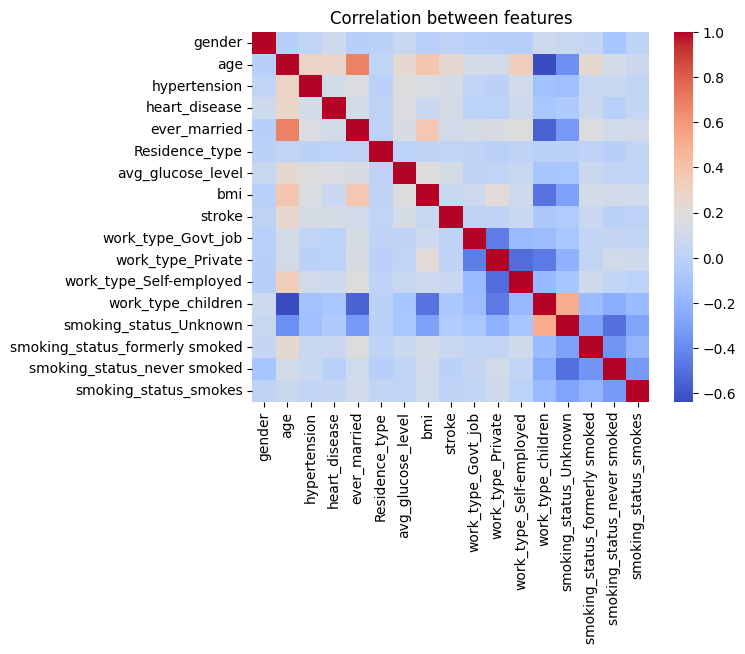

In [10]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation between features')
plt.show()

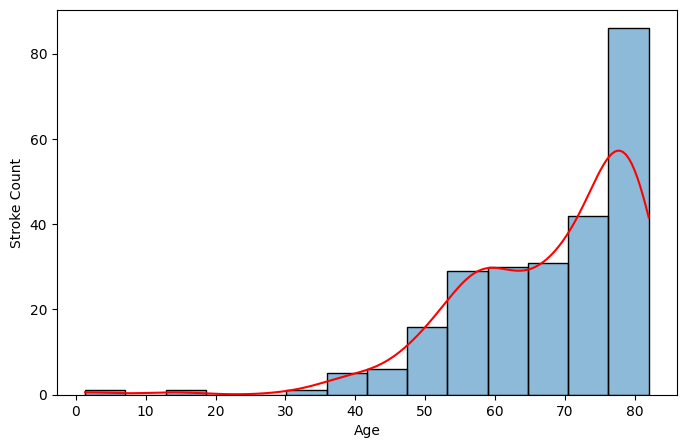

In [11]:
plt.figure(figsize=(8,5))
ax = sns.histplot(x=df['age'][df['stroke']==1], kde=True)
plt.xlabel('Age')
plt.ylabel('Stroke Count')
ax.lines[0].set_color('red')
plt.show()

In [12]:
stroke_hyperplus = df[(df['stroke']==1) & (df['hypertension']==1)]
stroke_hyperneg = df[(df['stroke']==1) & (df['hypertension']==0)]

perc_stroke_hyperplus = len(stroke_hyperplus)/(len(df[df['hypertension']==1])) * 100
perc_stroke_hyperneg = len(stroke_hyperneg)/(len(df[df['hypertension']==0])) * 100

print(f"stroke in people with hypertension is {round(perc_stroke_hyperplus, 2)}%")
print(f"stroke in people without hypertension is {round(perc_stroke_hyperneg, 2)}%")

stroke in people with hypertension is 13.78%
stroke in people without hypertension is 4.04%


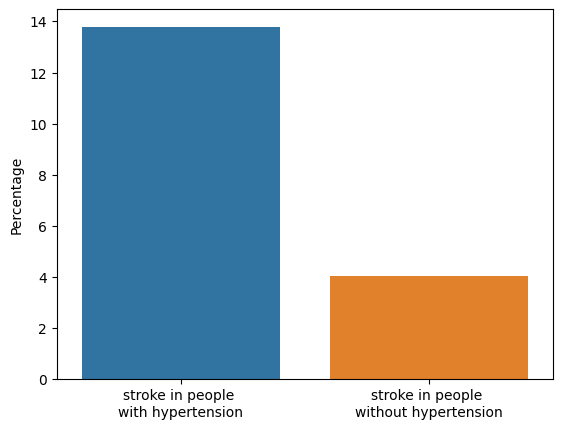

In [13]:
sns.barplot(x=["stroke in people \nwith hypertension", 'stroke in people \nwithout hypertension'],
            y=[perc_stroke_hyperplus, perc_stroke_hyperneg])
plt.ylabel('Percentage')
plt.show()

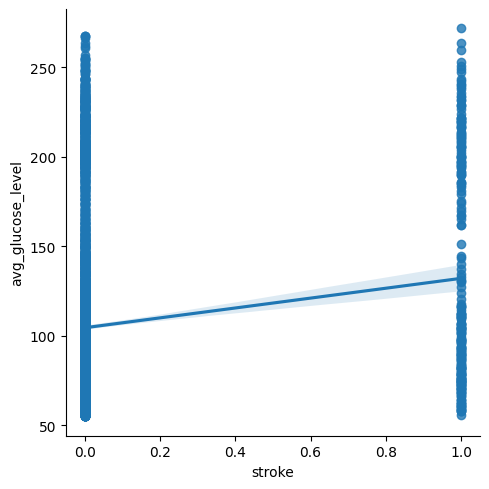

In [14]:
sns.lmplot(x='stroke', y='avg_glucose_level', data=df)
plt.show()

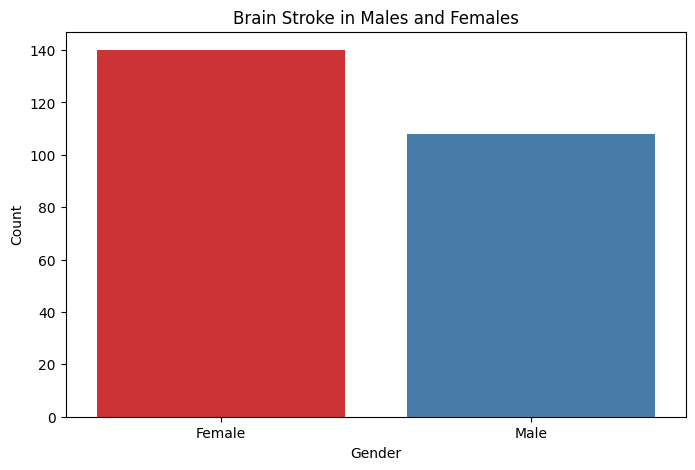

In [15]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['gender'][df['stroke']== 1], palette='Set1')

ax.set_xticklabels(['Female', 'Male'])
plt.title('Brain Stroke in Males and Females')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

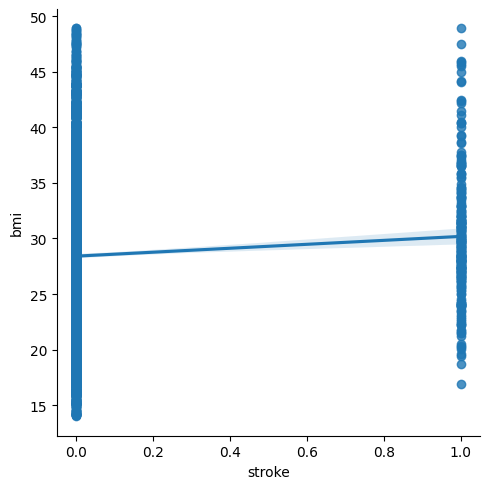

In [16]:
sns.lmplot(x='stroke', y='bmi', data=df)
plt.show()

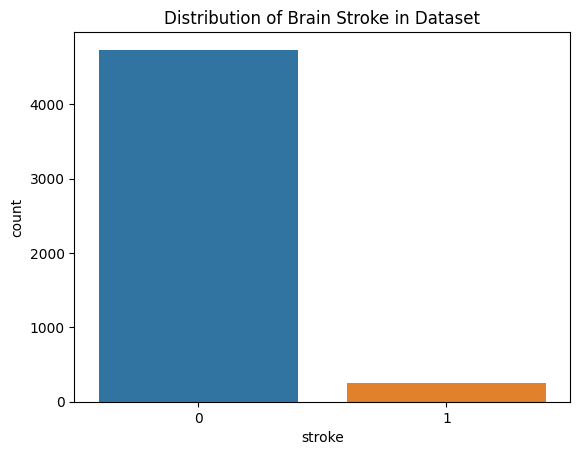

In [17]:
sns.countplot(x='stroke', data=df)
plt.title('Distribution of Brain Stroke in Dataset')

plt.show()

In [18]:
X = df.drop(['stroke'], axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

(y_train.shape, y_test.shape)

((3735,), (1246,))

Before balance:
stroke
0    3556
1     179
Name: count, dtype: int64


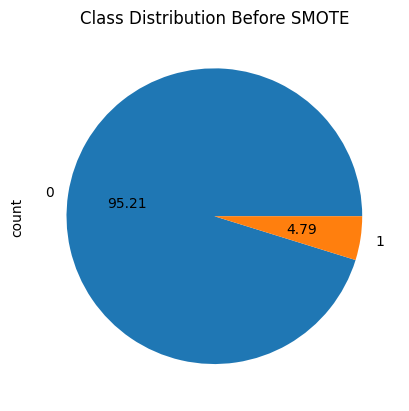


After balance:
stroke
0    3556
1    3556
Name: count, dtype: int64


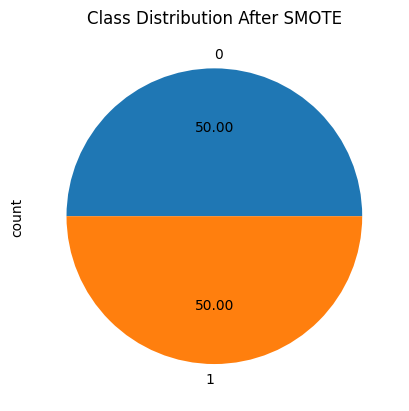

In [19]:
print('Before balance:')
print(y_train.value_counts())
y_train.value_counts().plot.pie(autopct='%.2f')
plt.title('Class Distribution Before SMOTE')
plt.show()

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print('\nAfter balance:')
print(y_train_sm.value_counts())
y_train_sm.value_counts().plot.pie(autopct='%.2f')
plt.title('Class Distribution After SMOTE')
plt.show()

In [20]:
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200, 300]
}

xgb_model = XGBClassifier(objective='binary:logistic', random_state = 42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='average_precision')

grid_search.fit(X_train_sm, y_train_sm)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters:  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}
Best score:  0.9949852550911229


In [21]:
xgboost_model = XGBClassifier(objective='binary:logistic',
                              n_estimators=300, 
                              max_depth=10,
                              learning_rate=0.1, 
                              random_state=42)

xgboost_model.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [22]:
y_pred = xgboost_model.predict(X_test)

In [23]:
print(f'Classification Report \n\n{classification_report(y_test, y_pred)}')

Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1177
           1       0.17      0.07      0.10        69

    accuracy                           0.93      1246
   macro avg       0.56      0.53      0.53      1246
weighted avg       0.90      0.93      0.92      1246



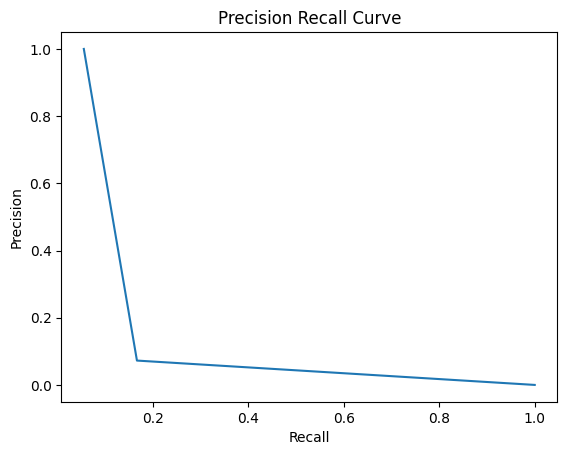

In [24]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(lr_precision,lr_recall)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision Recall Curve')
plt.show()

In [25]:
auc_pr = auc(lr_recall, lr_precision)
print("AUC-PR:", auc_pr)

AUC-PR: 0.14524740037685813


In [26]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(y_train_sm, xgboost_model.predict(X_train_sm)):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(y_test, y_pred):.4f}")

Metrics train:
	Accuracy score: 1.0000
Metrics test:
	Accuracy score: 0.9286


In [27]:
f1 = f1_score(y_test, y_pred)
print(f'f1-score : {f1: .4f}. ')

f1-score :  0.1010. 


In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc_score = roc_auc_score(y_test, y_pred)

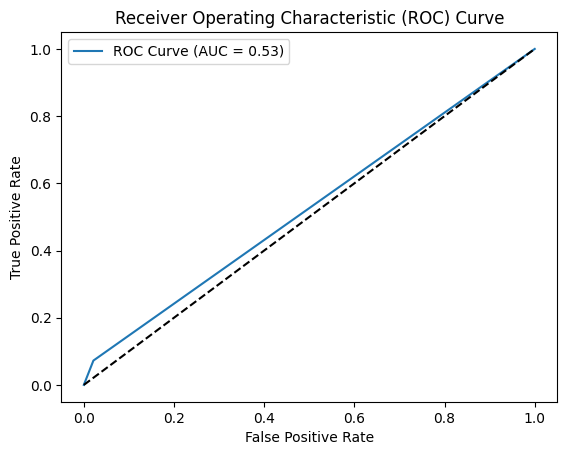

In [29]:
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [30]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_sm)
X_test_norm = scaler.transform(X_test)

In [31]:
deep_model = Sequential()
deep_model.add(Dense(400,activation='relu', input_shape=(X_train_norm.shape[1],)))
deep_model.add(Dropout(0.5))
deep_model.add(Dense(400,activation='relu'))
deep_model.add(Dropout(0.5))
deep_model.add(Dense(128,activation='relu'))
deep_model.add(Dense(1,activation='sigmoid'))

In [32]:
deep_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

In [33]:
deep_model.fit(X_train_norm, y_train_sm, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
223/223 [==============================] - 3s 9ms/step - loss: 0.2549 - accuracy: 0.8892 - precision: 0.8905 - recall: 0.8875
Epoch 2/10
223/223 [==============================] - 2s 8ms/step - loss: 0.1670 - accuracy: 0.9291 - precision: 0.9483 - recall: 0.9078
Epoch 3/10
223/223 [==============================] - 2s 9ms/step - loss: 0.1569 - accuracy: 0.9353 - precision: 0.9556 - recall: 0.9131
Epoch 4/10
223/223 [==============================] - 2s 8ms/step - loss: 0.1493 - accuracy: 0.9381 - precision: 0.9590 - recall: 0.9154
Epoch 5/10
223/223 [==============================] - 2s 8ms/step - loss: 0.1451 - accuracy: 0.9398 - precision: 0.9641 - recall: 0.9137
Epoch 6/10
223/223 [==============================] - 2s 9ms/step - loss: 0.1431 - accuracy: 0.9428 - precision: 0.9638 - recall: 0.9201
Epoch 7/10
223/223 [==============================] - 2s 10ms/step - loss: 0.1395 - accuracy: 0.9422 - precision: 0.9648 - recall: 0.9179
Epoch 8/10
223/223 [====================

In [34]:
y_pred = deep_model.predict(X_test_norm)
y_pred = (y_pred > 0.5).astype(int)

39/39 [==============================] - 0s 3ms/step


In [35]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9245585874799358


In [36]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.14285714285714285
Recall: 0.07246376811594203
F1-Score: 0.09615384615384616


In [37]:
print(f'Classification Report \n\n{classification_report(y_test, y_pred)}')

Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1177
           1       0.14      0.07      0.10        69

    accuracy                           0.92      1246
   macro avg       0.55      0.52      0.53      1246
weighted avg       0.90      0.92      0.91      1246



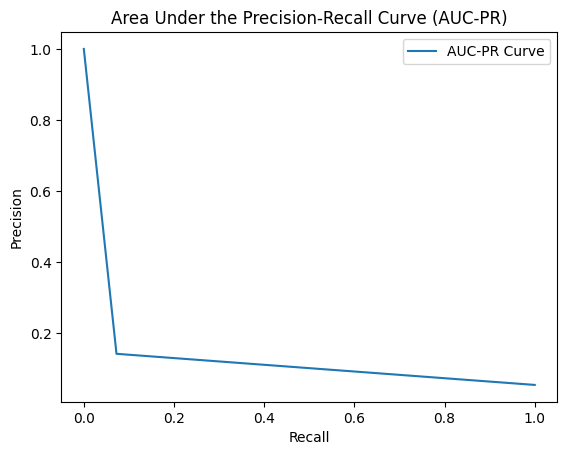

In [38]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(lr_recall, lr_precision, label='AUC-PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Area Under the Precision-Recall Curve (AUC-PR)')
plt.legend()
plt.show()

In [39]:
auc_pr = auc(lr_recall, lr_precision)
print("AUC-PR:", auc_pr)

AUC-PR: 0.1333426384720962


In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc_score = roc_auc_score(y_test, y_pred)

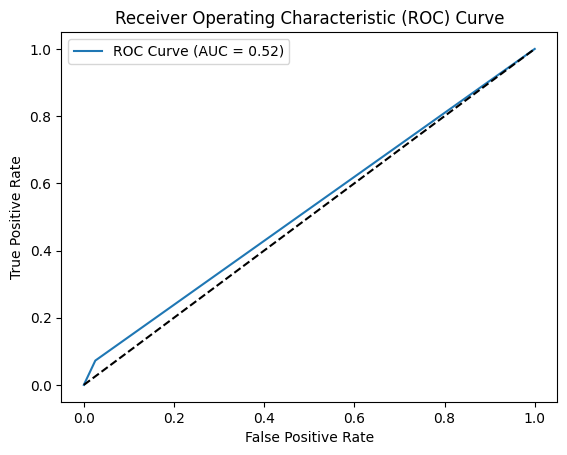

In [41]:
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()